In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import vector
import os
vector.register_awkward()
import mplhep
plt.style.use(mplhep.style.CMS)

In [2]:
def getBranch(data, l1jet):
    
    # Get list of branches relating to the given jet
    print("Getting list of interesting branches")
    interestingBranches = [branch for branch in data.keys() if l1jet in branch and not f"n{l1jet}" in branch]# and not f"{l1jet}_dau0" in branch] 
    
    # Get only branches corresponding to the desired l1jet
    print("Querying the array with interesting branches")
    l1jetData = data.arrays(interestingBranches)
    
    
    # Get a dictionary relating default branch names to new branch names (ie without leading ak8PuppiJets_...)
    print("Splitting branch names on _ to get renamed fields")
    renamedFields = {field : field.split('_', maxsplit=1)[-1] for field in interestingBranches}

    # Create a new awkward array with the desired l1jet branches and the new branch names
    print("Returning an ak array of the relevant data with the renamed fields")
    arr = ak.Array({renamedFields[field]: l1jetData[field] for field in l1jetData.fields})
    
    
    array_dict = {key: arr[key] for key in arr.fields}
    quarks4mom = ak.zip(array_dict)
    quarks4mom = ak.with_name(quarks4mom, "Momentum4D")
    
    
    return quarks4mom

In [34]:
file = uproot.open("/eos/user/d/ddharmen/updated_cmssw/CMSSW_14_0_0_pre3/src/FastPUPPI/NtupleProducer/python/perfNano_TTbar_PU200.root")
print(file.keys())
data = file["Events"]


['Events;1', 'LuminosityBlocks;1', 'Runs;1', 'MetaData;1', 'ParameterSets;1']


In [35]:
type(data)

uproot.models.TTree.Model_TTree_v20

In [36]:
sc8Jets_DC = getBranch(data=data, l1jet="HSC9x9SC8DCJets_")
sc8Jets = getBranch(data=data, l1jet="HSC9x9SC8Jets_")

Getting list of interesting branches
Querying the array with interesting branches
Splitting branch names on _ to get renamed fields
Returning an ak array of the relevant data with the renamed fields
Getting list of interesting branches
Querying the array with interesting branches
Splitting branch names on _ to get renamed fields
Returning an ak array of the relevant data with the renamed fields


In [41]:
fixedThresh = 500

In [42]:
gen_ht = ak.sum(sc8Jets_DC.genpt, axis=1)
l1_ht = ak.sum(sc8Jets_DC.pt, axis=1)


l1_ht_passedThresh = l1_ht > fixedThresh

ht_bins = np.linspace(0, 1000, 21)
bin_centres = (ht_bins[:-1] + ht_bins[1:]) / 2
efficiencies_DC = []
for binn in range(len(ht_bins) - 1):
    inBinMask = (gen_ht >= ht_bins[binn]) & (gen_ht < ht_bins[binn + 1])
    
    numerator = ak.sum(l1_ht_passedThresh[inBinMask])
    denominator = ak.sum(inBinMask)
    
    efficiencies_DC.append(numerator/denominator)

In [43]:
gen_ht = ak.sum(sc8Jets.genpt, axis=1)
l1_ht = ak.sum(sc8Jets.pt, axis=1)

l1_ht_passedThresh = l1_ht > fixedThresh

ht_bins = np.linspace(0, 1000, 21)
bin_centres = (ht_bins[:-1] + ht_bins[1:]) / 2
efficiencies = []
for binn in range(len(ht_bins) - 1):
    inBinMask = (gen_ht >= ht_bins[binn]) & (gen_ht < ht_bins[binn + 1])
    
    numerator = ak.sum(l1_ht_passedThresh[inBinMask])
    denominator = ak.sum(inBinMask)
    
    efficiencies.append(numerator/denominator)

AttributeError: Line2D.set() got an unexpected keyword argument 'fontsize'

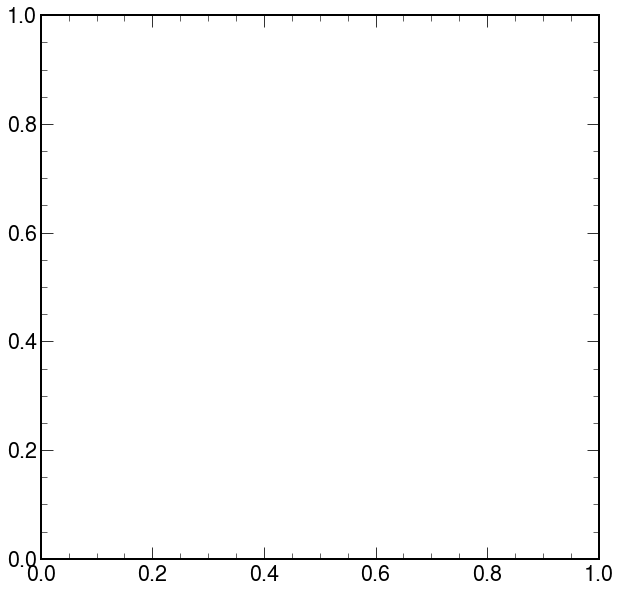

In [76]:
efficiencies = np.array(efficiencies)
plt.style.use(mplhep.style.ROOT)


# Plotting the efficiencies with matplotlib
# plt.figure(figsize=(8, 6))
plt.plot(bin_centres, efficiencies_DC, marker='o', linestyle='--', color='r', label=f' SC8 With DC (threshold: {fixedThresh})')
plt.plot(bin_centres, efficiencies, marker='o', linestyle='--', color='b', label=f'SC8 Without DC (threshold: {fixedThresh})')


# Set axis labels and title
plt.xlabel('Gen_HT [GeV]', fontsize=20, fontweight='bold')
plt.ylabel('Efficiency', fontsize=20, fontweight='bold')
plt.title('', fontsize=16)

# Add grid and customize tick marks
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Add a legend
plt.legend()
# mplhep.style.use({"font.sans-serif":'Comic Sans MS'})
mplhep.cms.label("", data=False, com= 14, rlabel = "PU =200")
# Show the plot
plt.show()
plt.savefig("perf.pdf")

ValueError: x and y must have same first dimension, but have shapes (20,) and (2,)

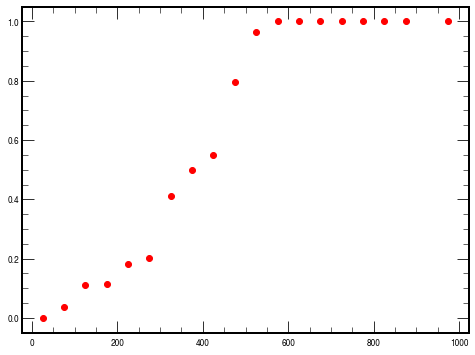

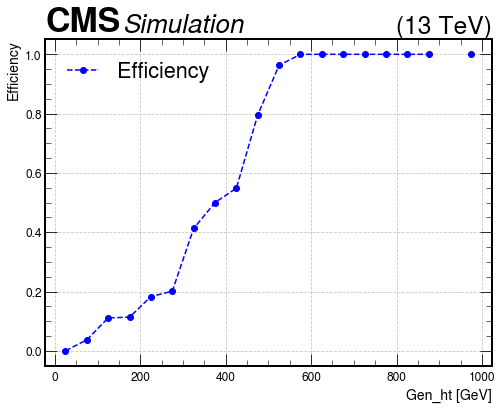

In [27]:
plt.style.use(mplhep.style.ROOT)
plt.figure(figsize=(8, 6))
plt.plot(bin_centres, efficiencies, marker='o', linestyle='--', color='b', label='Efficiency')

# Set axis labels and title with a larger font size
plt.xlabel('Gen_ht [GeV]', fontsize=14)
plt.ylabel('Efficiency', fontsize=14)
plt.title('', fontsize=16)

# Add a grid with dashed lines and some transparency
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust the tick sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a legend
plt.legend()

# Use mplhep CMS label if desired (optional)
mplhep.cms.label()

# Show the plot
plt.show()


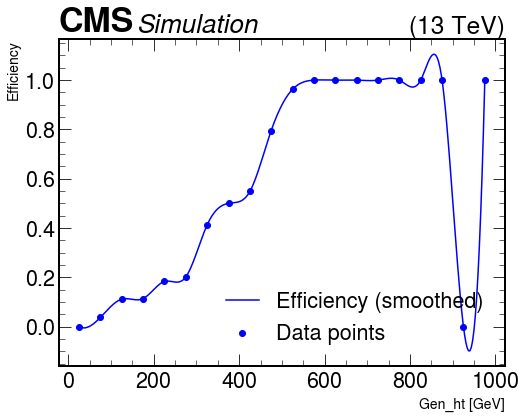

In [28]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import mplhep
from scipy.interpolate import make_interp_spline  # For smoothing

# Use the ROOT style for the plot
plt.style.use(mplhep.style.ROOT)

# Assuming 'sc8Jets_DC', 'gen_ht', 'l1_ht', 'l1_ht_passedThresh' have already been calculated

# Define the bins for HT
ht_bins = np.linspace(0, 1000, 21)  # Bins from 0 to 1000 with 21 intervals
bin_centres = (ht_bins[:-1] + ht_bins[1:]) / 2  # Calculate the bin centers

# Initialize an empty list to store efficiencies
efficiencies = []

# Loop through each bin and calculate the efficiency
for binn in range(len(ht_bins) - 1):
    # Create a mask for entries that fall within the current bin
    inBinMask = (gen_ht >= ht_bins[binn]) & (gen_ht < ht_bins[binn + 1])
    
    # Calculate the numerator and denominator for the efficiency
    numerator = ak.sum(l1_ht_passedThresh[inBinMask])
    denominator = ak.sum(inBinMask)
    
    # Append the efficiency (numerator/denominator) to the efficiencies list
    efficiency = numerator / denominator if denominator != 0 else 0
    efficiencies.append(efficiency)

# Convert efficiencies to a numpy array for plotting
efficiencies = np.array(efficiencies)

# Smoothing the curve with spline interpolation
xnew = np.linspace(bin_centres.min(), bin_centres.max(), 300)  # 300 points for smoothness
spl = make_interp_spline(bin_centres, efficiencies, k=3)  # Cubic spline interpolation
eff_smooth = spl(xnew)

# Plotting the efficiencies with a smoother curve
plt.figure(figsize=(8, 6))
plt.plot(xnew, eff_smooth, color='b', label='Efficiency (smoothed)')  # Smoothed curve
plt.scatter(bin_centres, efficiencies, color='b', marker='o', label='Data points')  # Original data points

# Set axis labels and title with a larger font size
plt.xlabel('Gen_ht [GeV]', fontsize=14)
plt.ylabel('Efficiency', fontsize=14)

# Add a legend
plt.legend()

# Use mplhep CMS label if desired (optional)
mplhep.cms.label()

# Show the plot
plt.show()
